## Load the data in pickle file 

In [1]:
## Load the data
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as netcdf

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

In [2]:
import os 

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


### Load the real observations

In [3]:
import netCDF4 as netcdf

# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

time_period = 33
grid_lat_size = lat.shape[0]
grid_lon_size = lon.shape[0]

# Preprocessing of the data: $(x_{i,t,m}^{p})_{i=1,\ldots,I, t=1,\ldots,T,m=1,\ldots,M, p=1,\ldots,d}$
## $i$: ensemble member (run) index
## $t$: time index
## $m$: model index
## $p$: grid cell index

#### Keep the model with at least 3 ensemble memebers and downscale the data from latitude 144 -> 36 with local averaging (to match with ensemble methods

In [4]:
import skimage

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))
            lat_size = dic_reduced_ssp585[m][i][0,:,:].shape[0]
            lon_size = dic_reduced_ssp585[m][i][0,:,:].shape[1]

In [5]:
nan_idx = []
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    for idx_i,i in enumerate(dic_reduced_ssp585[m].keys()):    
        # for t in enumerate(range(time_period)[:2]):
            # print(np.where(np.isnan(dic_reduced_ssp585[m][i][t,:,:].ravel())==True))
        nan_idx_tmp = list(np.where(np.isnan(dic_reduced_ssp585[m][i][0,:,:].ravel())==True)[0])
        # nan_idx_tmp_tt = list(np.where(np.isnan(dic_reduced_ssp585[m][i][1,:,:].ravel())==True)[0])
        
        nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

### 1) Compute anomalies: $\displaystyle \overline{x}_{i,t,m}^p = x_{i,t,m}^p - \frac{1}{t_{\mathrm{ref}}^f - t_{\mathrm{ref}}^s} \sum_{t= t_{\mathrm{ref}}^s}^{t_{\mathrm{ref}}^f} \sum_{i=1}^I x_{i,t,m}^p$

In [6]:
# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')
        
        
        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(y_tmp,axis=0)/ len(dic_reduced_ssp585[m].keys())
        else:
            mean_ref_ensemble += np.nanmean(y_tmp,axis=0)/ len(dic_reduced_ssp585[m].keys())

    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        dic_processed_ssp585[m][i] = y_tmp - mean_ref_ensemble

/tmp/ipykernel_33347/3205467388.py:16: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp,axis=0)/ len(dic_reduced_ssp585[m].keys())
/tmp/ipykernel_33347/3205467388.py:18: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(y_tmp,axis=0)/ len(dic_reduced_ssp585[m].keys())


### 2) Compute the forced response: 
#### - Mean over space: $\displaystyle y_{i,t,m} = \frac{1}{P} \sum_{p=1}^P x_{i,t,m}^p$
#### - Mean over ensemble members: $\displaystyle \overline{y}_{t,m} = \frac{1}{I} \sum_{i=1}^I y_{i,t,m}$
#### - Set the mean to all the ensemble member forced responses: $y_{i,t,m} \colon= \overline{y}_{t,m}$
#### - Centering with respect to a given reference period: $\displaystyle y_{i,t,m} = y_{i,t,m} - \frac{1}{t_{\mathrm{ref}}^f - t_{\mathrm{ref}}^s} \sum_{t= t_{\mathrm{ref}}^s}^{t_{\mathrm{ref}}^f} \overline{y}_{t,m}$

In [7]:
# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')

        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(y_tmp,axis=1)/ len(dic_forced_response_ssp585[m].keys())
        else:
            mean_spatial_ensemble += np.nanmean(y_tmp,axis=1)/ len(dic_forced_response_ssp585[m].keys())

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble)
        # print(dic_forced_response_ssp585[m][i].shape)

## Now we can use the data to run some simple regression models

In [8]:
time_period = 33
grid_lat_size = 36
grid_lon_size = 72

In [9]:
y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = {}
    x_predictor[m] = {}

    
    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_forced_response[m][i] = dic_forced_response_ssp585[m][i]
        x_predictor[m][i] = dic_processed_ssp585[m][i]
        x_predictor[m][i][:,nan_idx] = float('nan')      

In [10]:
y_forced_response_concatenate = {}
x_predictor_concatenate = {}
count_x = 0


for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response_concatenate[m] = 0
    x_predictor_concatenate[m] = 0

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        count_x += len(dic_processed_ssp585[m].keys())*33
        
        if idx_i ==0:
            y_forced_response_concatenate[m] = dic_forced_response_ssp585[m][i]
            x_predictor_concatenate[m] = dic_processed_ssp585[m][i]
        else:
            y_forced_response_concatenate[m] = np.concatenate([y_forced_response_concatenate[m],dic_forced_response_ssp585[m][i]])
            x_predictor_concatenate[m] = np.concatenate([x_predictor_concatenate[m], dic_processed_ssp585[m][i]],axis=0)  
    x_predictor_concatenate[m][:,nan_idx] = float('nan')

In [11]:
import torch 

# compute the variance
variance_processed_ssp585 = {}
std_processed_ssp585 = {}
for idx_m,m in enumerate(x_predictor.keys()):
    variance_processed_ssp585[m] = {}
    arr_tmp = np.zeros((len(x_predictor[m].keys()),33))
    
    for idx_i, i in enumerate(list(x_predictor[m].keys())):
        arr_tmp[idx_i,:] = np.nanmean(x_predictor[m][i],axis=1)

    arr_tmp_values = np.zeros((len(x_predictor[m].keys()),33))
    for idx_i, i in enumerate(x_predictor[m].keys()):
        arr_tmp_values[idx_i,:] = (y_forced_response[m][i] - arr_tmp[idx_i,:])**2

    variance_processed_ssp585[m] = torch.mean(torch.nanmean(torch.from_numpy(arr_tmp_values),axis=0))

In [12]:
import torch

# Data preprocessing
x_train = {}
y_train = {}

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    x_train[m] = torch.nan_to_num(torch.from_numpy(x_predictor_concatenate[m])).to(torch.float64)
    y_train[m] = torch.from_numpy(y_forced_response_concatenate[m]).to(torch.float64)

### Define deep autoencoder with Pytorch

In [13]:
import torch.nn as nn
torch.set_default_dtype(torch.float64)

# Define the Deep Autoencoder architecture
class DeepAutoencoder(nn.Module):
    def __init__(self, input_size, hidden_size,output_size):
        super(DeepAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, hidden_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_size),
            # nn.Sigmoid()  # Sigmoid activation for pixel values between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Huber loss function
class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super(HuberLoss, self).__init__()
        self.delta = delta
        self.loss = nn.SmoothL1Loss(reduction='mean')

    def forward(self, y_true, y_pred):
        residual = torch.abs(y_true - y_pred)
        condition = (residual < self.delta).float()
        loss = condition * 0.5 * residual ** 2 + (1 - condition) * (self.delta * residual - 0.5 * self.delta ** 2)
        return torch.mean(loss)

In [14]:
def autoencoder_training_test(x,y,batch_number,input_size, hidden_size,output_size,num_epochs=100):

    # input_size = (1, number of grid cells)
    # hidden size = arbitrary low number (1000?)
    
    # Create the Deep Autoencoder model
    model = DeepAutoencoder(input_size, hidden_size, output_size)
    
    # Define least squares loss function and optimizer
    criterion = nn.MSELoss()
    # criterion = HuberLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


    for epoch in range(num_epochs):

        loss = torch.tensor(0.0)
        for i in range(batch_number):
            
            inputs = x[i*33:(i+1)*33,:].ravel().detach()
        
            # Forward pass
            beta = model(inputs)
        
            # Compute least squares loss
            loss += criterion(y[i*33:(i+1)*33], torch.matmul(x[i*33:(i+1)*33,:],beta)) + 10.0*torch.norm(beta,p=2)**2
            # loss = criterion(y, beta)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # Print progress
        if epoch%10==0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


    return model,beta

In [15]:
# concatenate several model runs
x_tmp = 0  
y_tmp = 0

x_test = 0  
y_test = 0

batch_number = 0
for idx_m, m in enumerate(dic_reduced_ssp585.keys()):
    if m!= 'KACE-1-0-G':
        batch_number += len(dic_reduced_ssp585[m].keys())
        if idx_m == 0:
            x_tmp = x_train[m]
            y_tmp = y_train[m]
        else:
            x_tmp = torch.cat((x_tmp,x_train[m]),0)
            y_tmp = torch.cat((y_tmp,y_train[m]),0)

    else:
        x_test = x_train[m]  
        y_test = y_train[m]

In [16]:
# input_size = x_train[m].shape[0]*grid_lon_size*grid_lat_size
input_size = 33*grid_lon_size*grid_lat_size
hidden_size = 100
output_size = grid_lon_size*grid_lat_size

model,beta = autoencoder_training_test(x_tmp,y_tmp,batch_number,input_size, hidden_size,output_size,num_epochs=200)
# model,beta = autoencoder_training_test(x_train[m],y_train[m],len(dic_reduced_ssp585[m].keys()),input_size, hidden_size,output_size,num_epochs=100)

Epoch [1/200], Loss: 27899.0325
Epoch [11/200], Loss: 11466.1344
Epoch [21/200], Loss: 3077.9368
Epoch [31/200], Loss: 1004.6702
Epoch [41/200], Loss: 233.2539
Epoch [51/200], Loss: 181.8917
Epoch [61/200], Loss: 64.0480
Epoch [71/200], Loss: 35.9571
Epoch [81/200], Loss: 19.7888
Epoch [91/200], Loss: 16.2550
Epoch [101/200], Loss: 12.3444
Epoch [111/200], Loss: 10.4675
Epoch [121/200], Loss: 9.0700
Epoch [131/200], Loss: 11.9549
Epoch [141/200], Loss: 55.8813
Epoch [151/200], Loss: 38.1361
Epoch [161/200], Loss: 16.4768
Epoch [171/200], Loss: 12.0829
Epoch [181/200], Loss: 7.3813
Epoch [191/200], Loss: 5.5951


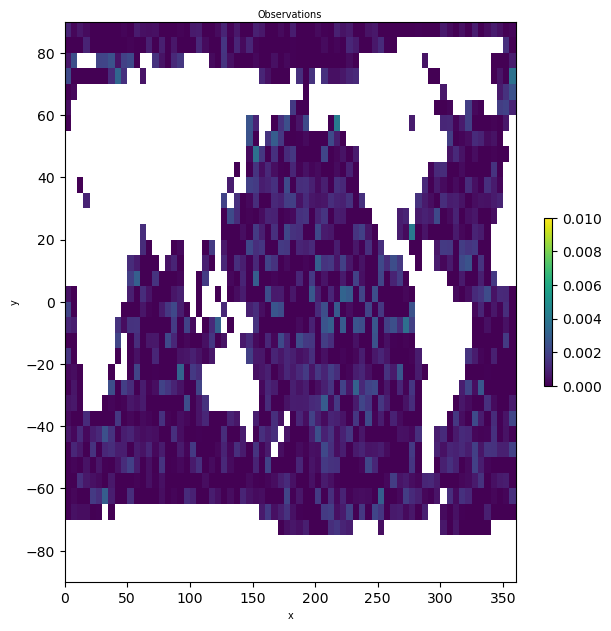

In [20]:
# define beta to plot
beta_tmp = beta.detach().clone()
beta_tmp[nan_idx] = float('nan')
beta_tmp = beta_tmp.detach().numpy().reshape(lat.shape[0],lon.shape[0])

fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(2, 2, 1)        
ax0.set_title('Observations', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,beta_tmp,vmin=-0.00,vmax = 0.01)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)


plt.show()

# Deep Variational Autoencoder (VAE) with a a loss robust towards out-of-distribution samples